In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier as KNC
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import dataset
DR_df = pd.read_csv("../Resources/DR_complete_clean_scaled.csv")
DR_df.head()

,class_,u_,g_,r_,i_,z_,redshift_
0,2,-1.067720,-1.123867,-0.878764,-0.036867,-0.558164,-0.713568
1,2,-0.030126,-0.487516,-0.660599,-0.035391,-0.668300,-0.713270
2,2,-0.429575,-0.452186,-0.317882,-0.009295,-0.131955,-0.713123
3,2,0.489953,0.523653,0.409810,0.026467,0.430269,-0.713607
4,2,-1.644429,-1.964525,-2.027211,-0.111112,-1.892926,-0.713444


In [2]:
print(DR_df.keys())

Index(['class_', 'u_', 'g_', 'r_', 'i_', 'z_', 'redshift_'], dtype='object')


In [3]:
X = DR_df.drop('class_', axis=1) # independent features
y = DR_df['class_'] # Target

Real world data often contains considerably different numbers of samples for the classes to learn (class imbalance). Training a classifier on an unbalanced data set could introduce a classification bias. A common method to avoid this bias, is to stratify the data by over- or under-sampling samples based on their class labels.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In laymans, model complexity can be summarized as follows:  

- Larger k = smoother decision boundar = less complex model
- Smaller k = can lead to overfitting = more complex model

So we will develop a curve for the training and testing data.
We will compute and plot the training and testing accuracy scores for a variety of different neighbor values. By observing how the accuracy scores differ for the training and testing sets with different values of k, we will develop an intuition for overfitting and underfitting.

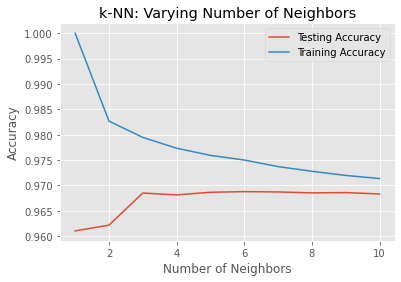

In [5]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNC(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [6]:
# Fitting the model
knn = KNC(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

## Assessing the model

In [7]:
# Accuracy score
score = knn.score(X_test, y_test)
print("Accuracy = Fraction of correct predictions")
print("Test set accuracy:\n{}".format(score))

Accuracy = Fraction of correct predictions
Test set accuracy:
0.9685070943861813


In [8]:
# Computing Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[19544   173   337]
 [  420  4610     9]
 [   82     0  7245]]


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     20054
           1       0.96      0.91      0.94      5039
           2       0.95      0.99      0.97      7327

    accuracy                           0.97     32420
   macro avg       0.96      0.96      0.96     32420
weighted avg       0.97      0.97      0.97     32420



## Applying SMOTE
We will use MinMaxScaler from scikit-learn to scale columns that have values greater than 1 to [0, 1] range. Here’ how:

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Scale only columns that have values greater than 1
to_scale = [col for col in DR_df.columns if DR_df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(DR_df[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    if(col != 'class_'):
        DR_df[col] = scaled[col]
    
DR_df.head()

,class_,u_,g_,r_,i_,z_,redshift_
0,2,0.421106,0.413640,0.401527,-0.036867,0.425911,0.001513
1,2,0.543768,0.480139,0.420240,-0.035391,0.416062,0.001543
2,2,0.496546,0.483831,0.449635,-0.009295,0.464025,0.001558
3,2,0.605251,0.585806,0.512051,0.026467,0.514302,0.001509
4,2,0.352929,0.325790,0.303021,-0.111112,0.306550,0.001525


In [11]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X = DR_df.drop('class_', axis=1) # independent features
y = DR_df['class_'] # Target

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (108066, 6)
Shape of X after SMOTE: (200538, 6)

Balance of positive and negative classes (%):


2    33.333333
1    33.333333
0    33.333333
Name: class_, dtype: float64

Now that we have applied SMOTE to our features and stored the results in dedicated variables, the new feature and target set is larger due to oversampling. We will not rerun the KNN model on the dataset.

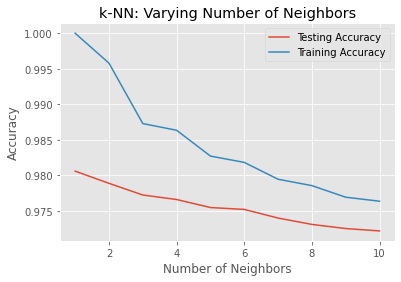

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=21, stratify=y_sm)

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNC(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [13]:
knn = KNC(n_neighbors = 4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

## Assessing the model with SMOTE applied

In [14]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

score = knn.score(X_test, y_test)
print("Test set accuracy:\n{}".format(score))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     20054
           1       0.98      0.97      0.98     20054
           2       0.98      1.00      0.99     20054

    accuracy                           0.98     60162
   macro avg       0.98      0.98      0.98     60162
weighted avg       0.98      0.98      0.98     60162

Test set accuracy:
0.9765965227219839


In [15]:
print(confusion_matrix(y_test, y_pred))

[[19254   434   366]
 [  506 19524    24]
 [   69     9 19976]]
